# Introduction

In this lab, we will apply Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) on a corpus of documents to extract additive models of the topic structure of the corpus. The output will be a plot of topics, each represented as a bar plot using the top few words based on weights.

# Load the Dataset

We will load the 20 newsgroups dataset and vectorize it. We use a few heuristics to filter out useless terms early on: the posts are stripped of headers, footers and quoted replies, and common English words, words occurring in only one document, or in at least 95% of the documents are removed.

In [1]:
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000

print('Loading dataset...')
data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=('headers', 'footers', 'quotes'),
    return_X_y=True
)
data_samples = data[:n_samples]

Loading dataset...


# Extract Features

We will extract features from the dataset using tf-idf features for NMF and raw term count features for LDA.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Use tf-idf features for NMF.
print('Extracting tf-idf features for NMF...')
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words='english'
)
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Use raw term count features for LDA
print('Extracting tf features for LDA...')
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words='english'
)
tf = tf_vectorizer.fit_transform(data_samples)

Extracting tf-idf features for NMF...
Extracting tf features for LDA...


# Apply NMF

We will apply NMF with two different objective functions: the Frobenius norm and the generalized Kullback-Leibler divergence. The latter is equivalent to Probabilistic Latent Semantic Indexing.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


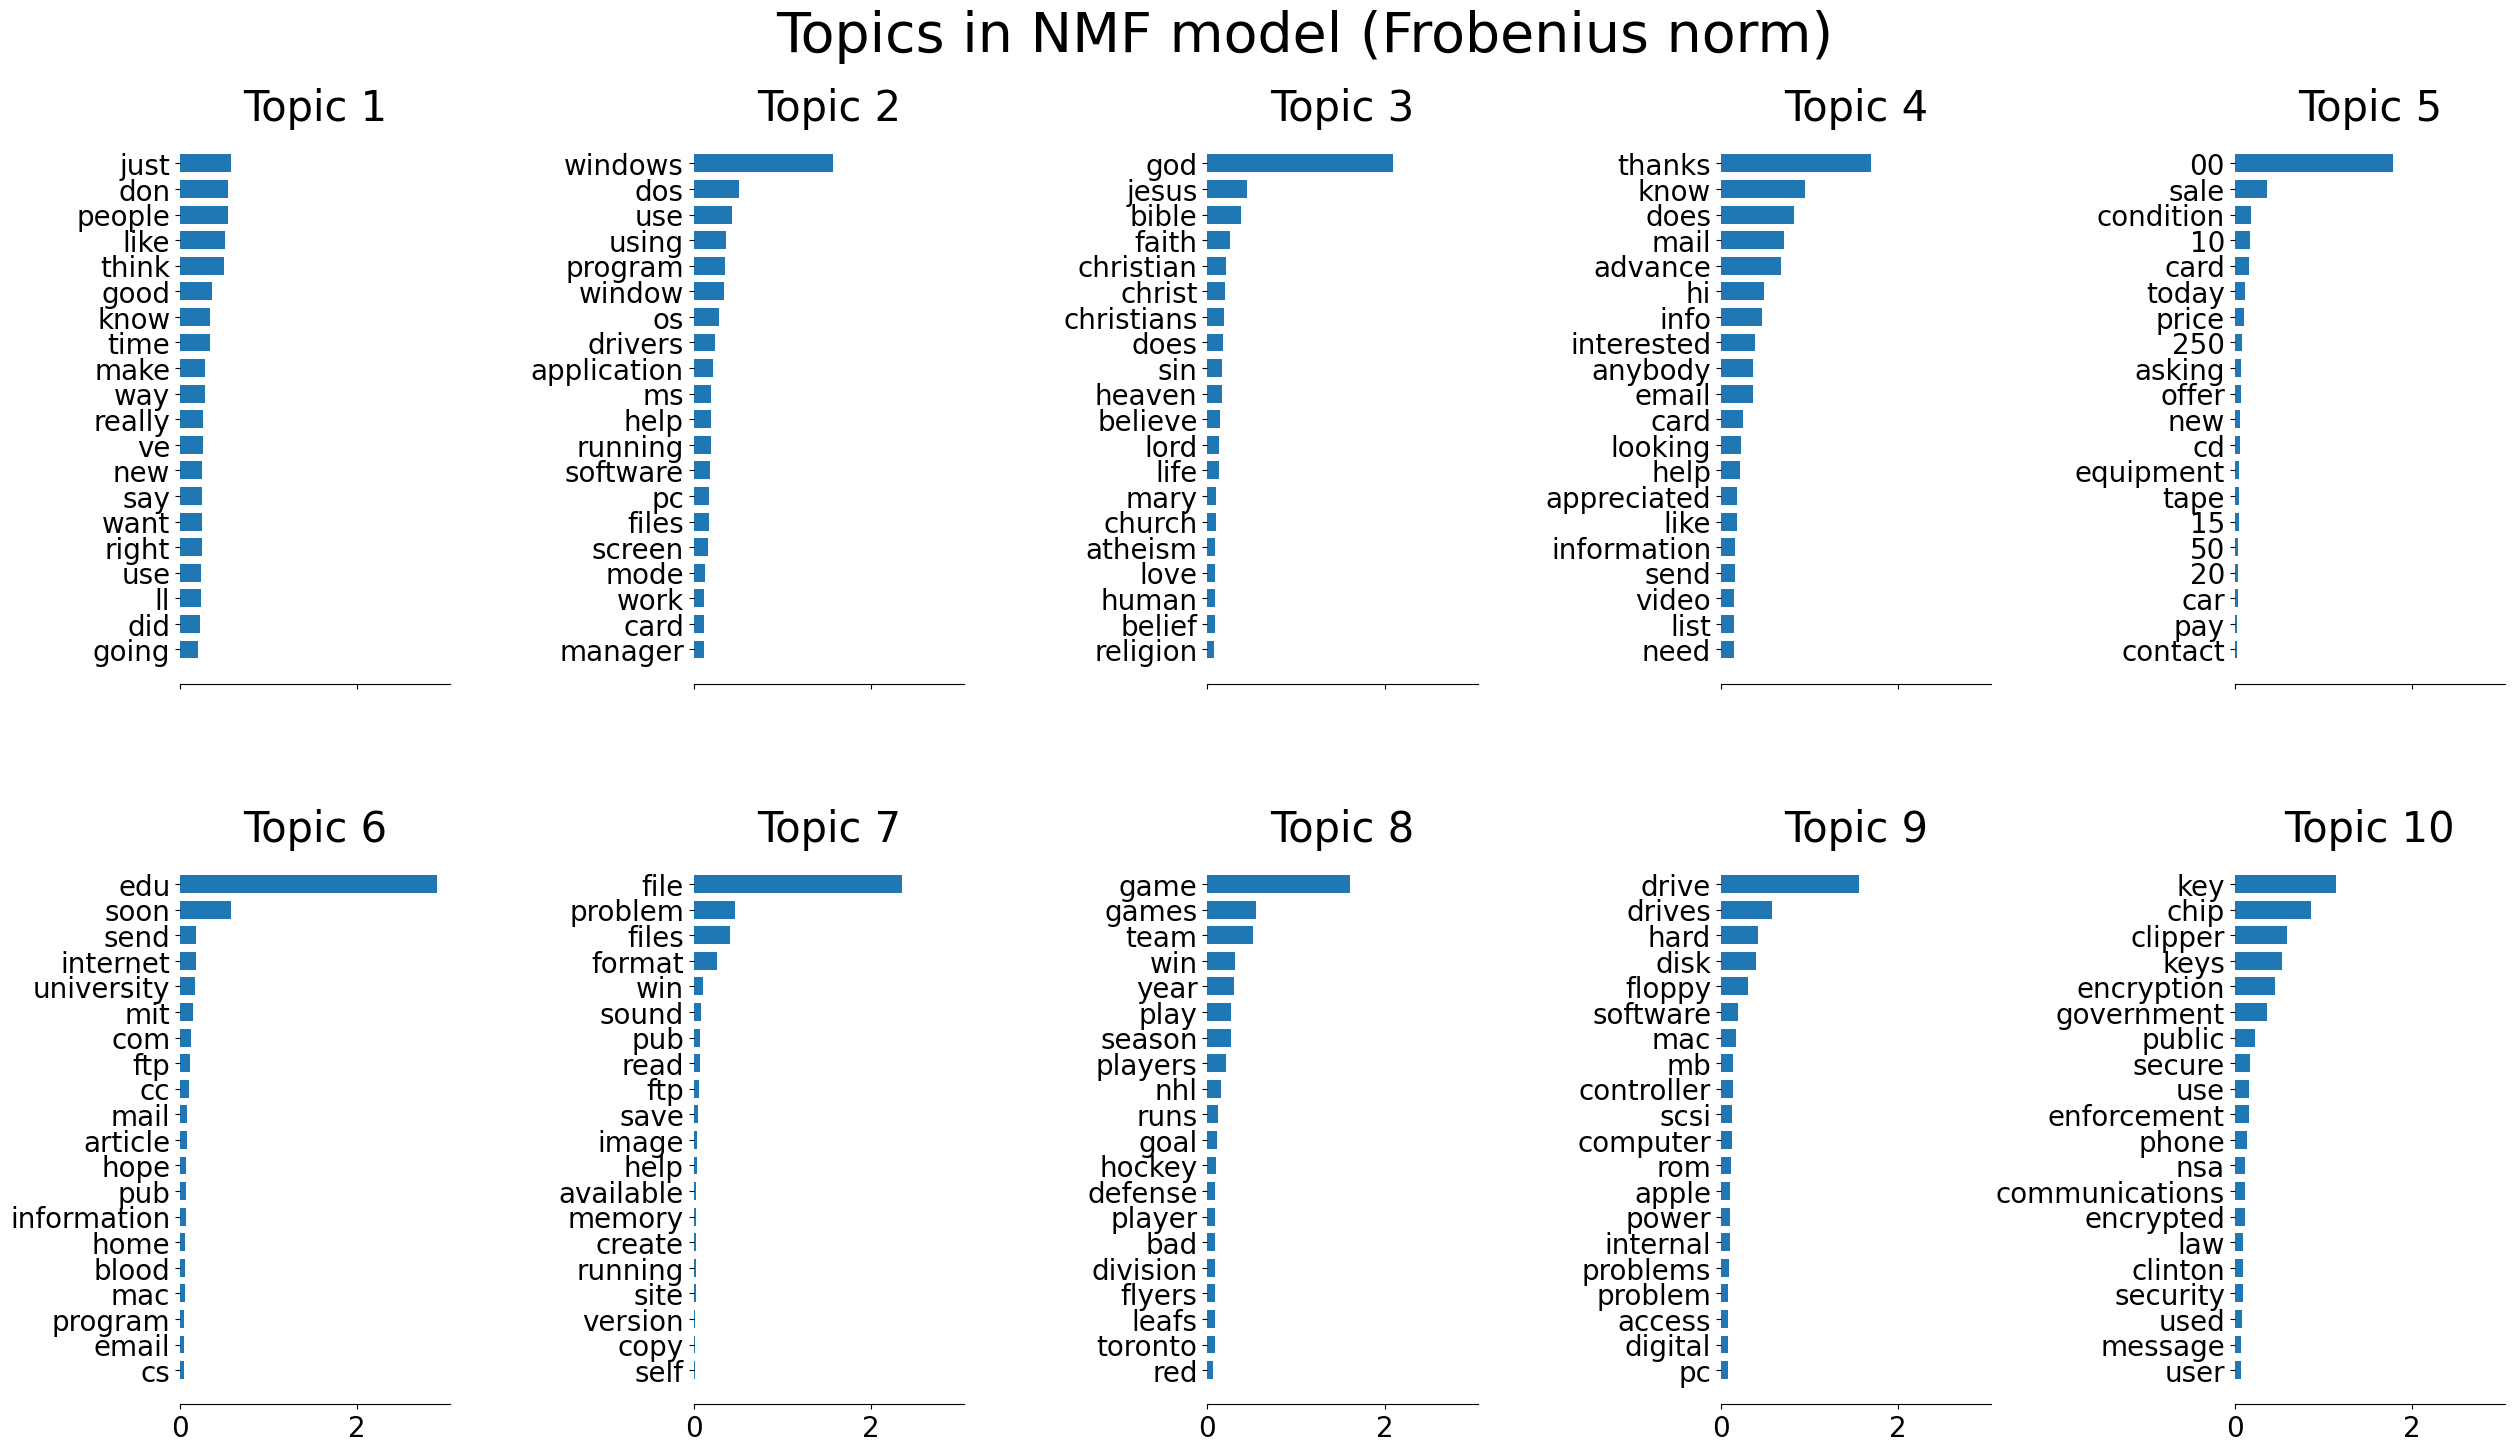



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


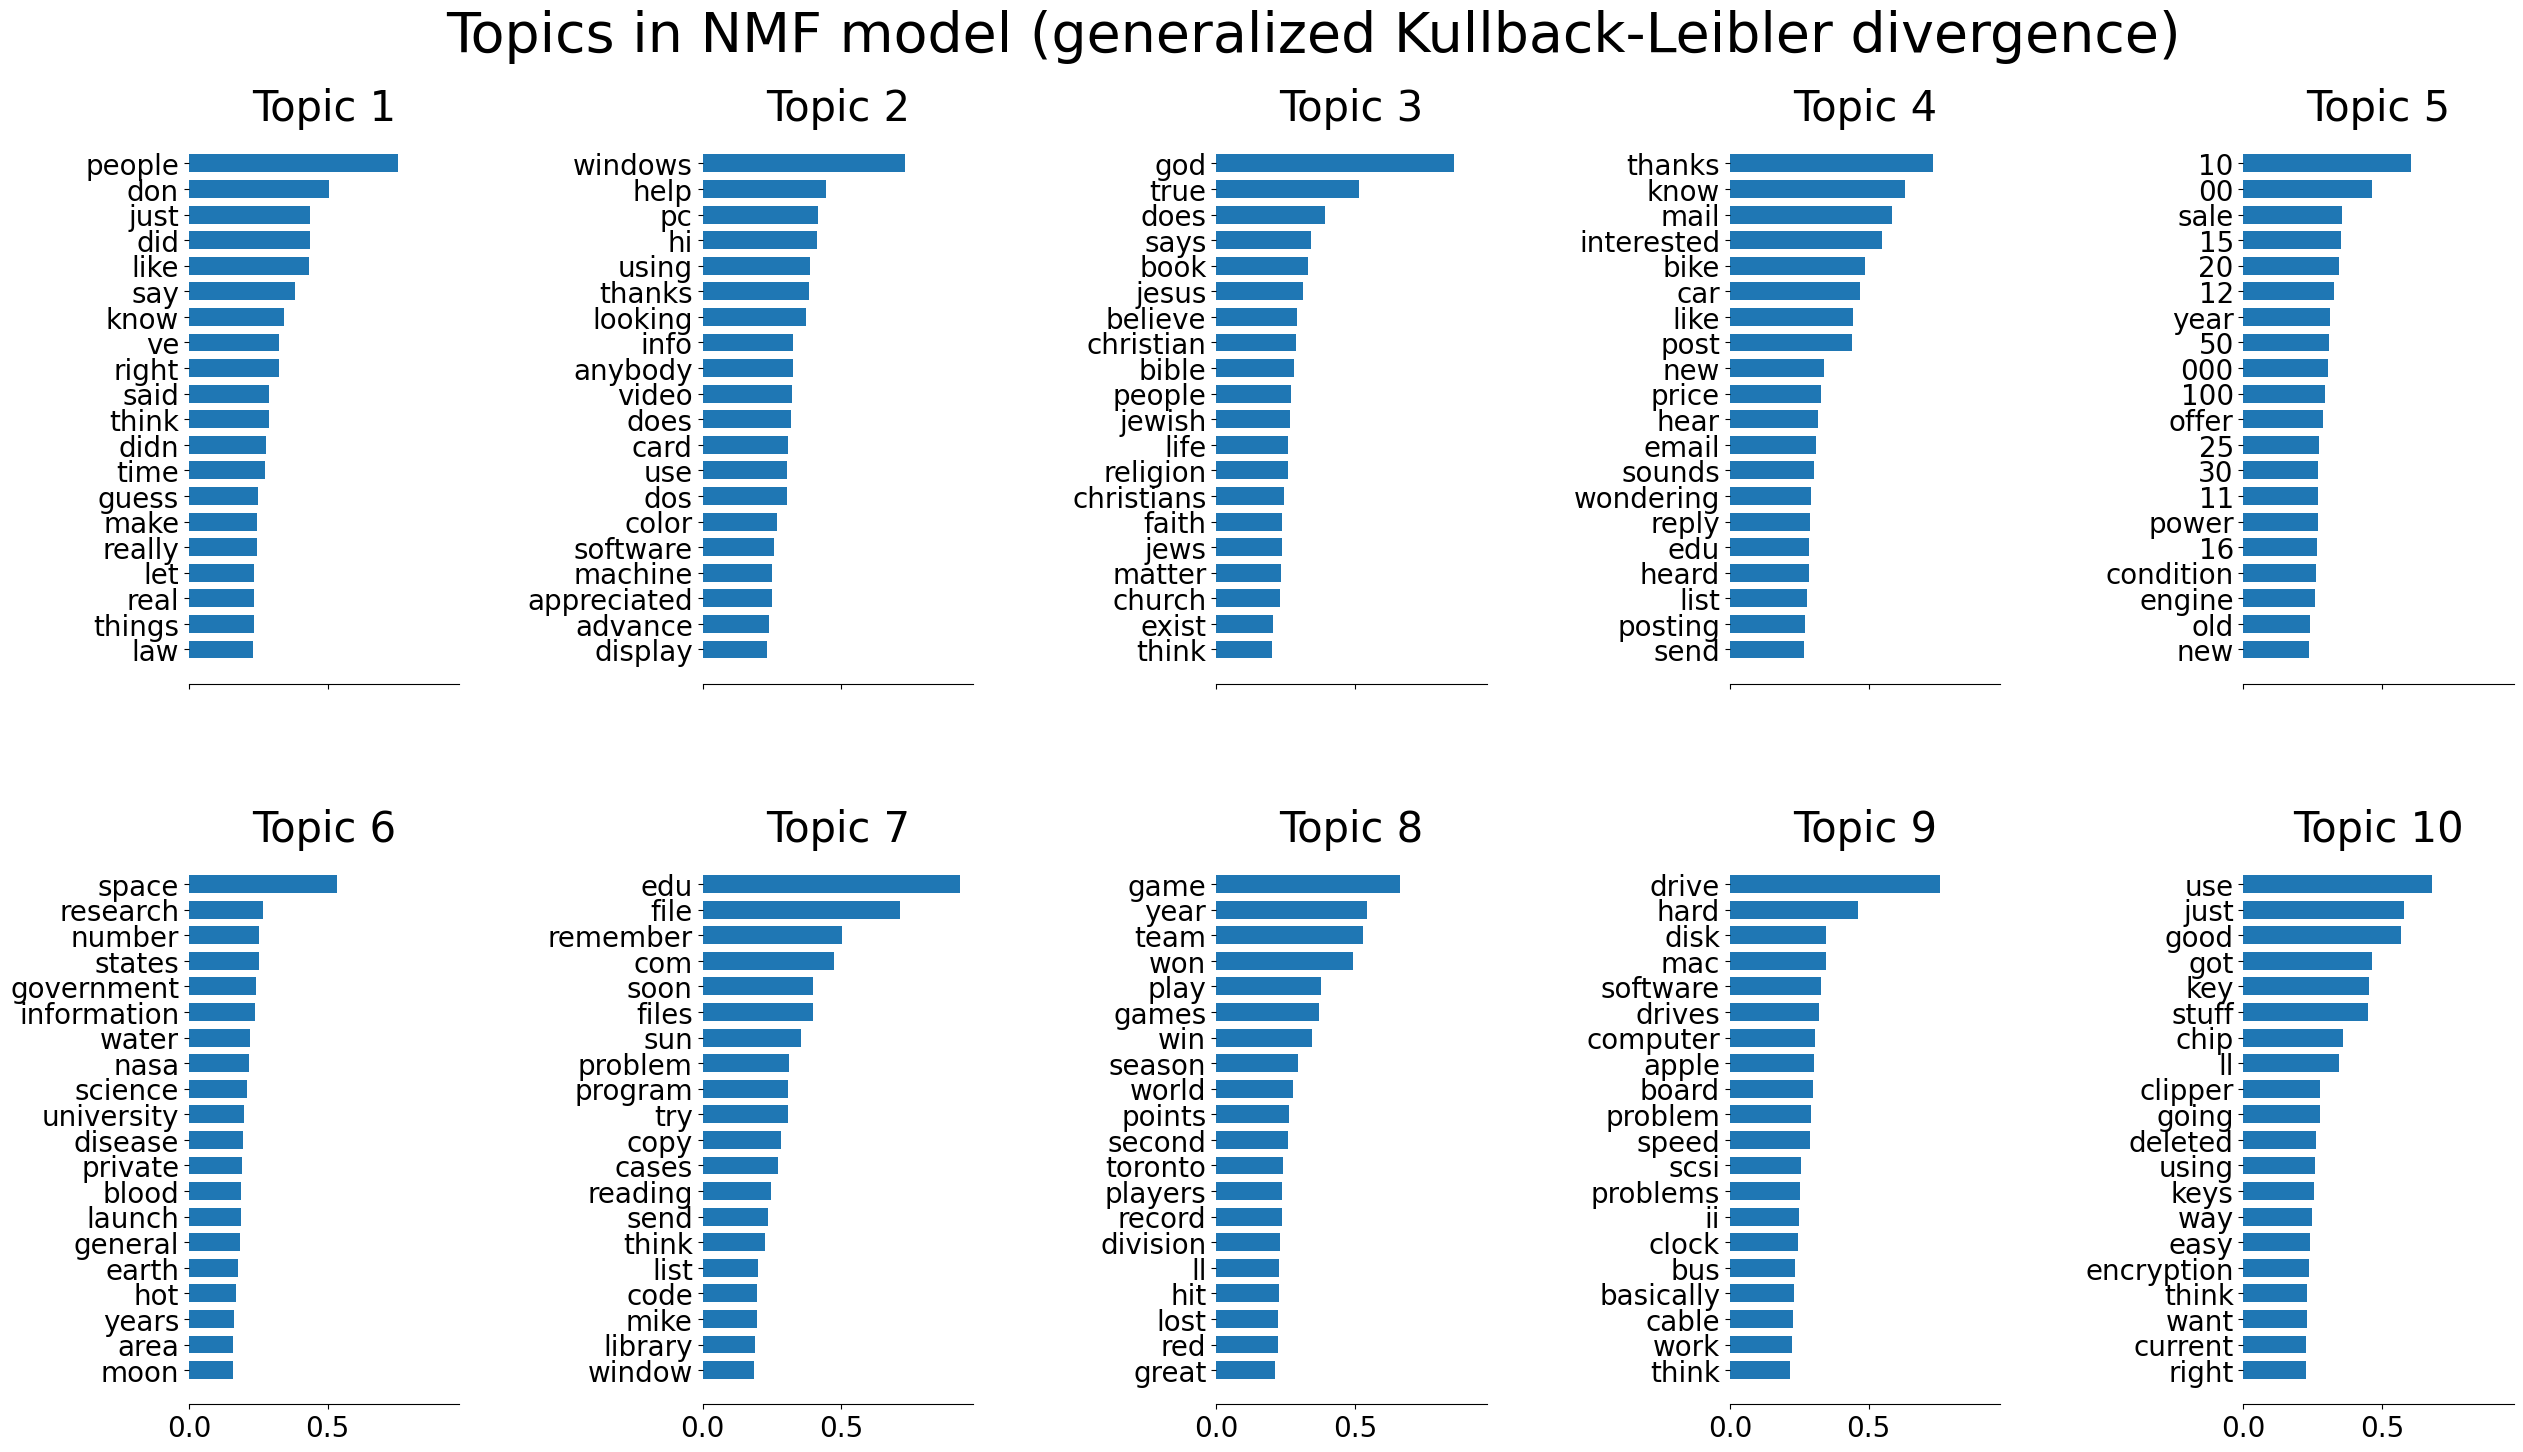



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


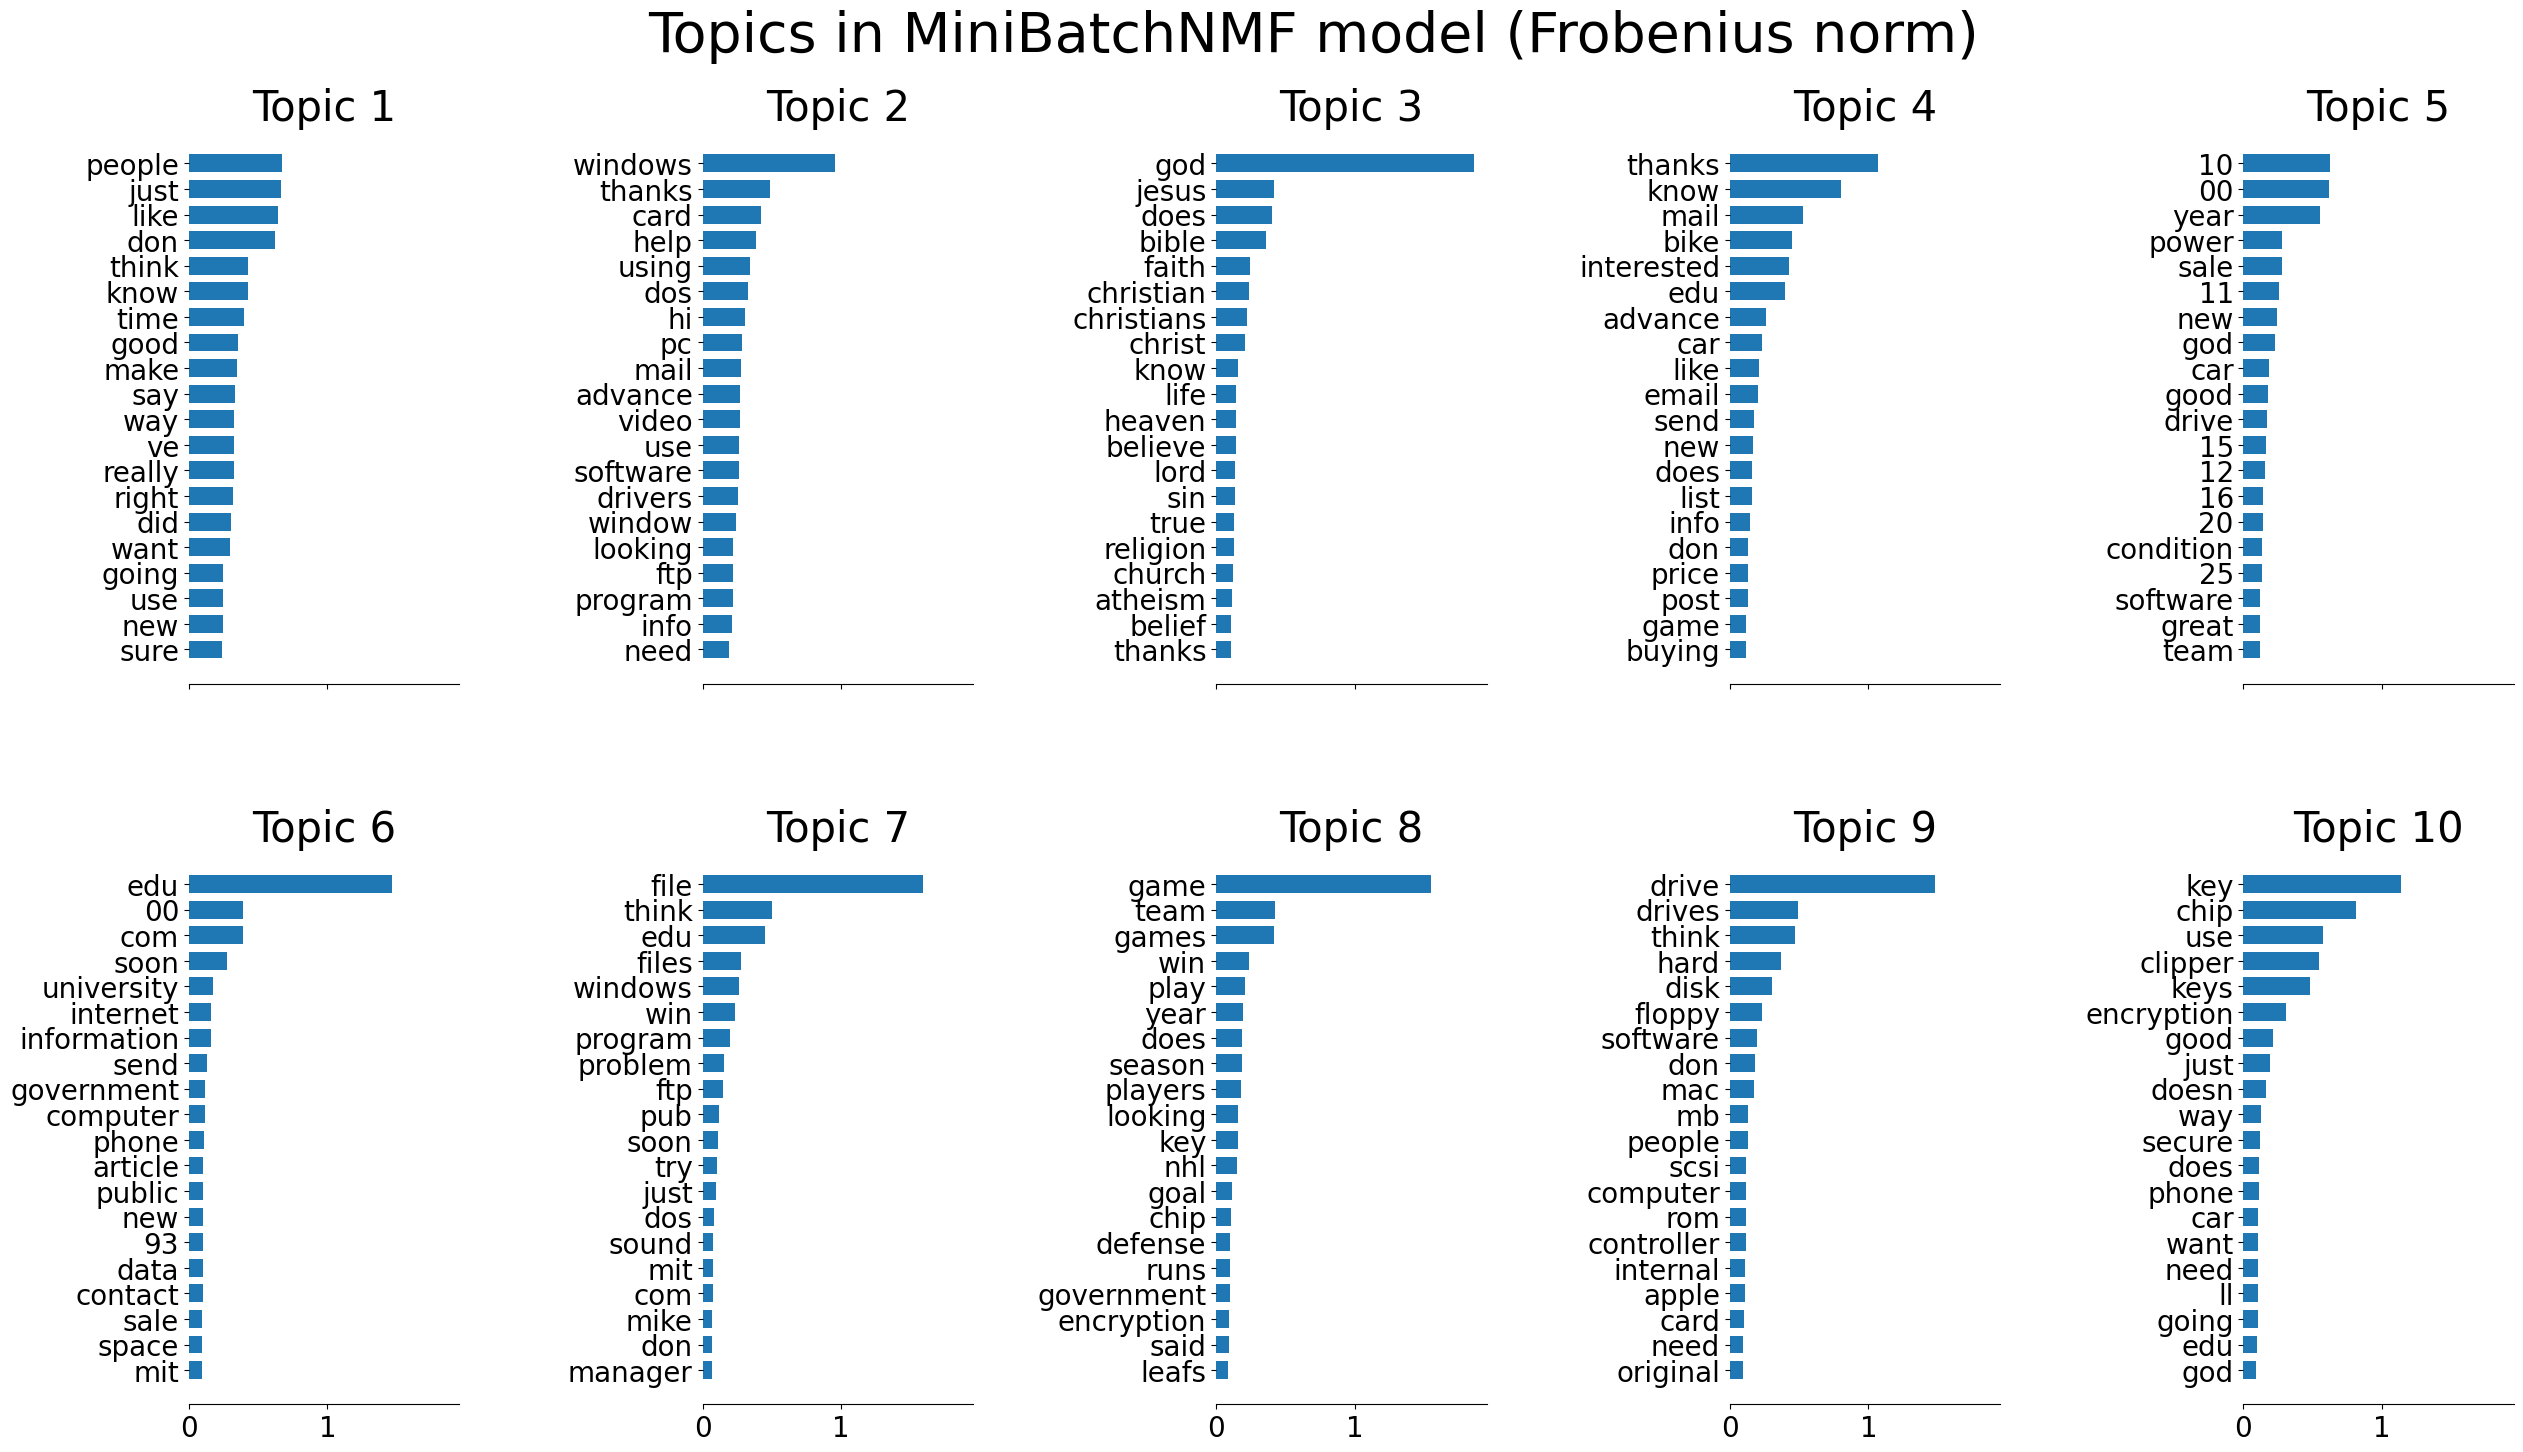



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


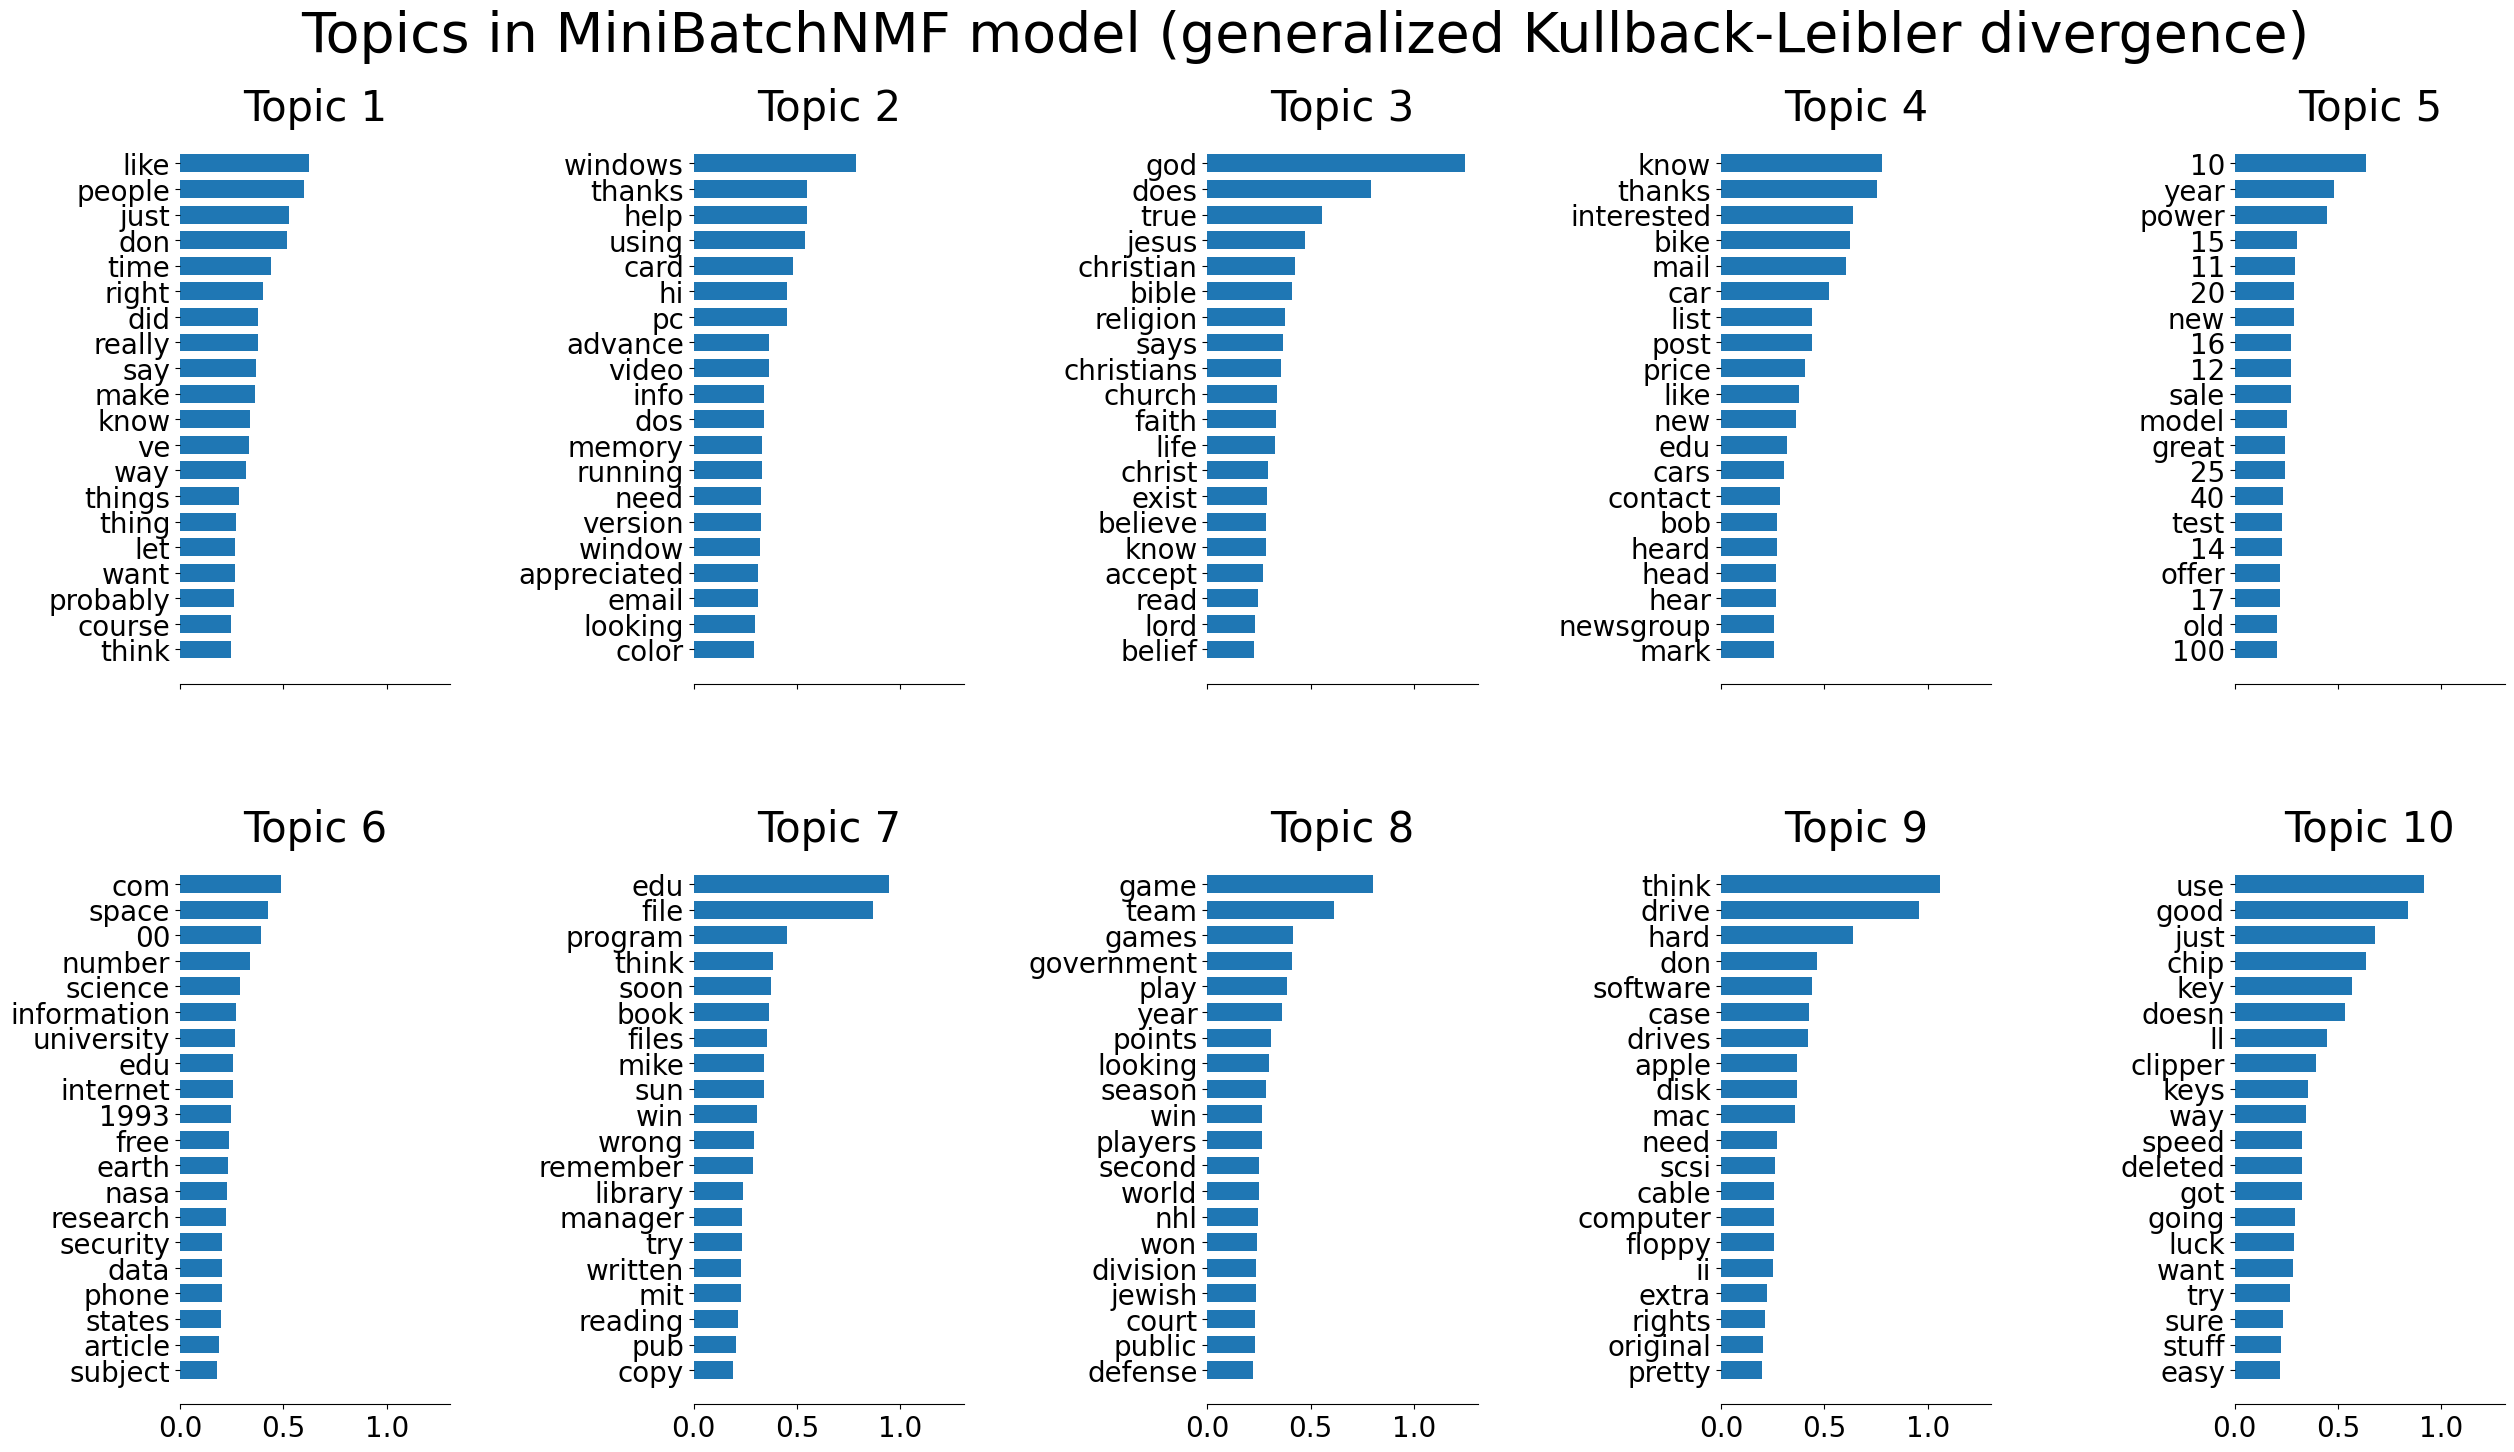

In [4]:
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

n_components = 10
n_top_words = 20
init = "nndsvda"

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)

# Plot the top words for the NMF model
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model with the generalized Kullback-Leibler divergence
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

# Plot the top words for the NMF model with the generalized Kullback-Leibler divergence
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Fit the MiniBatchNMF model
from sklearn.decomposition import MiniBatchNMF

batch_size = 128

print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

# Plot the top words for the MiniBatchNMF model with the Frobenius norm
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Fit the MiniBatchNMF model with the generalized Kullback-Leibler divergence
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

# Plot the top words for the MiniBatchNMF model with the generalized Kullback-Leibler divergence
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

# Apply LDA

We will apply LDA models with tf features.



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 1.027s.


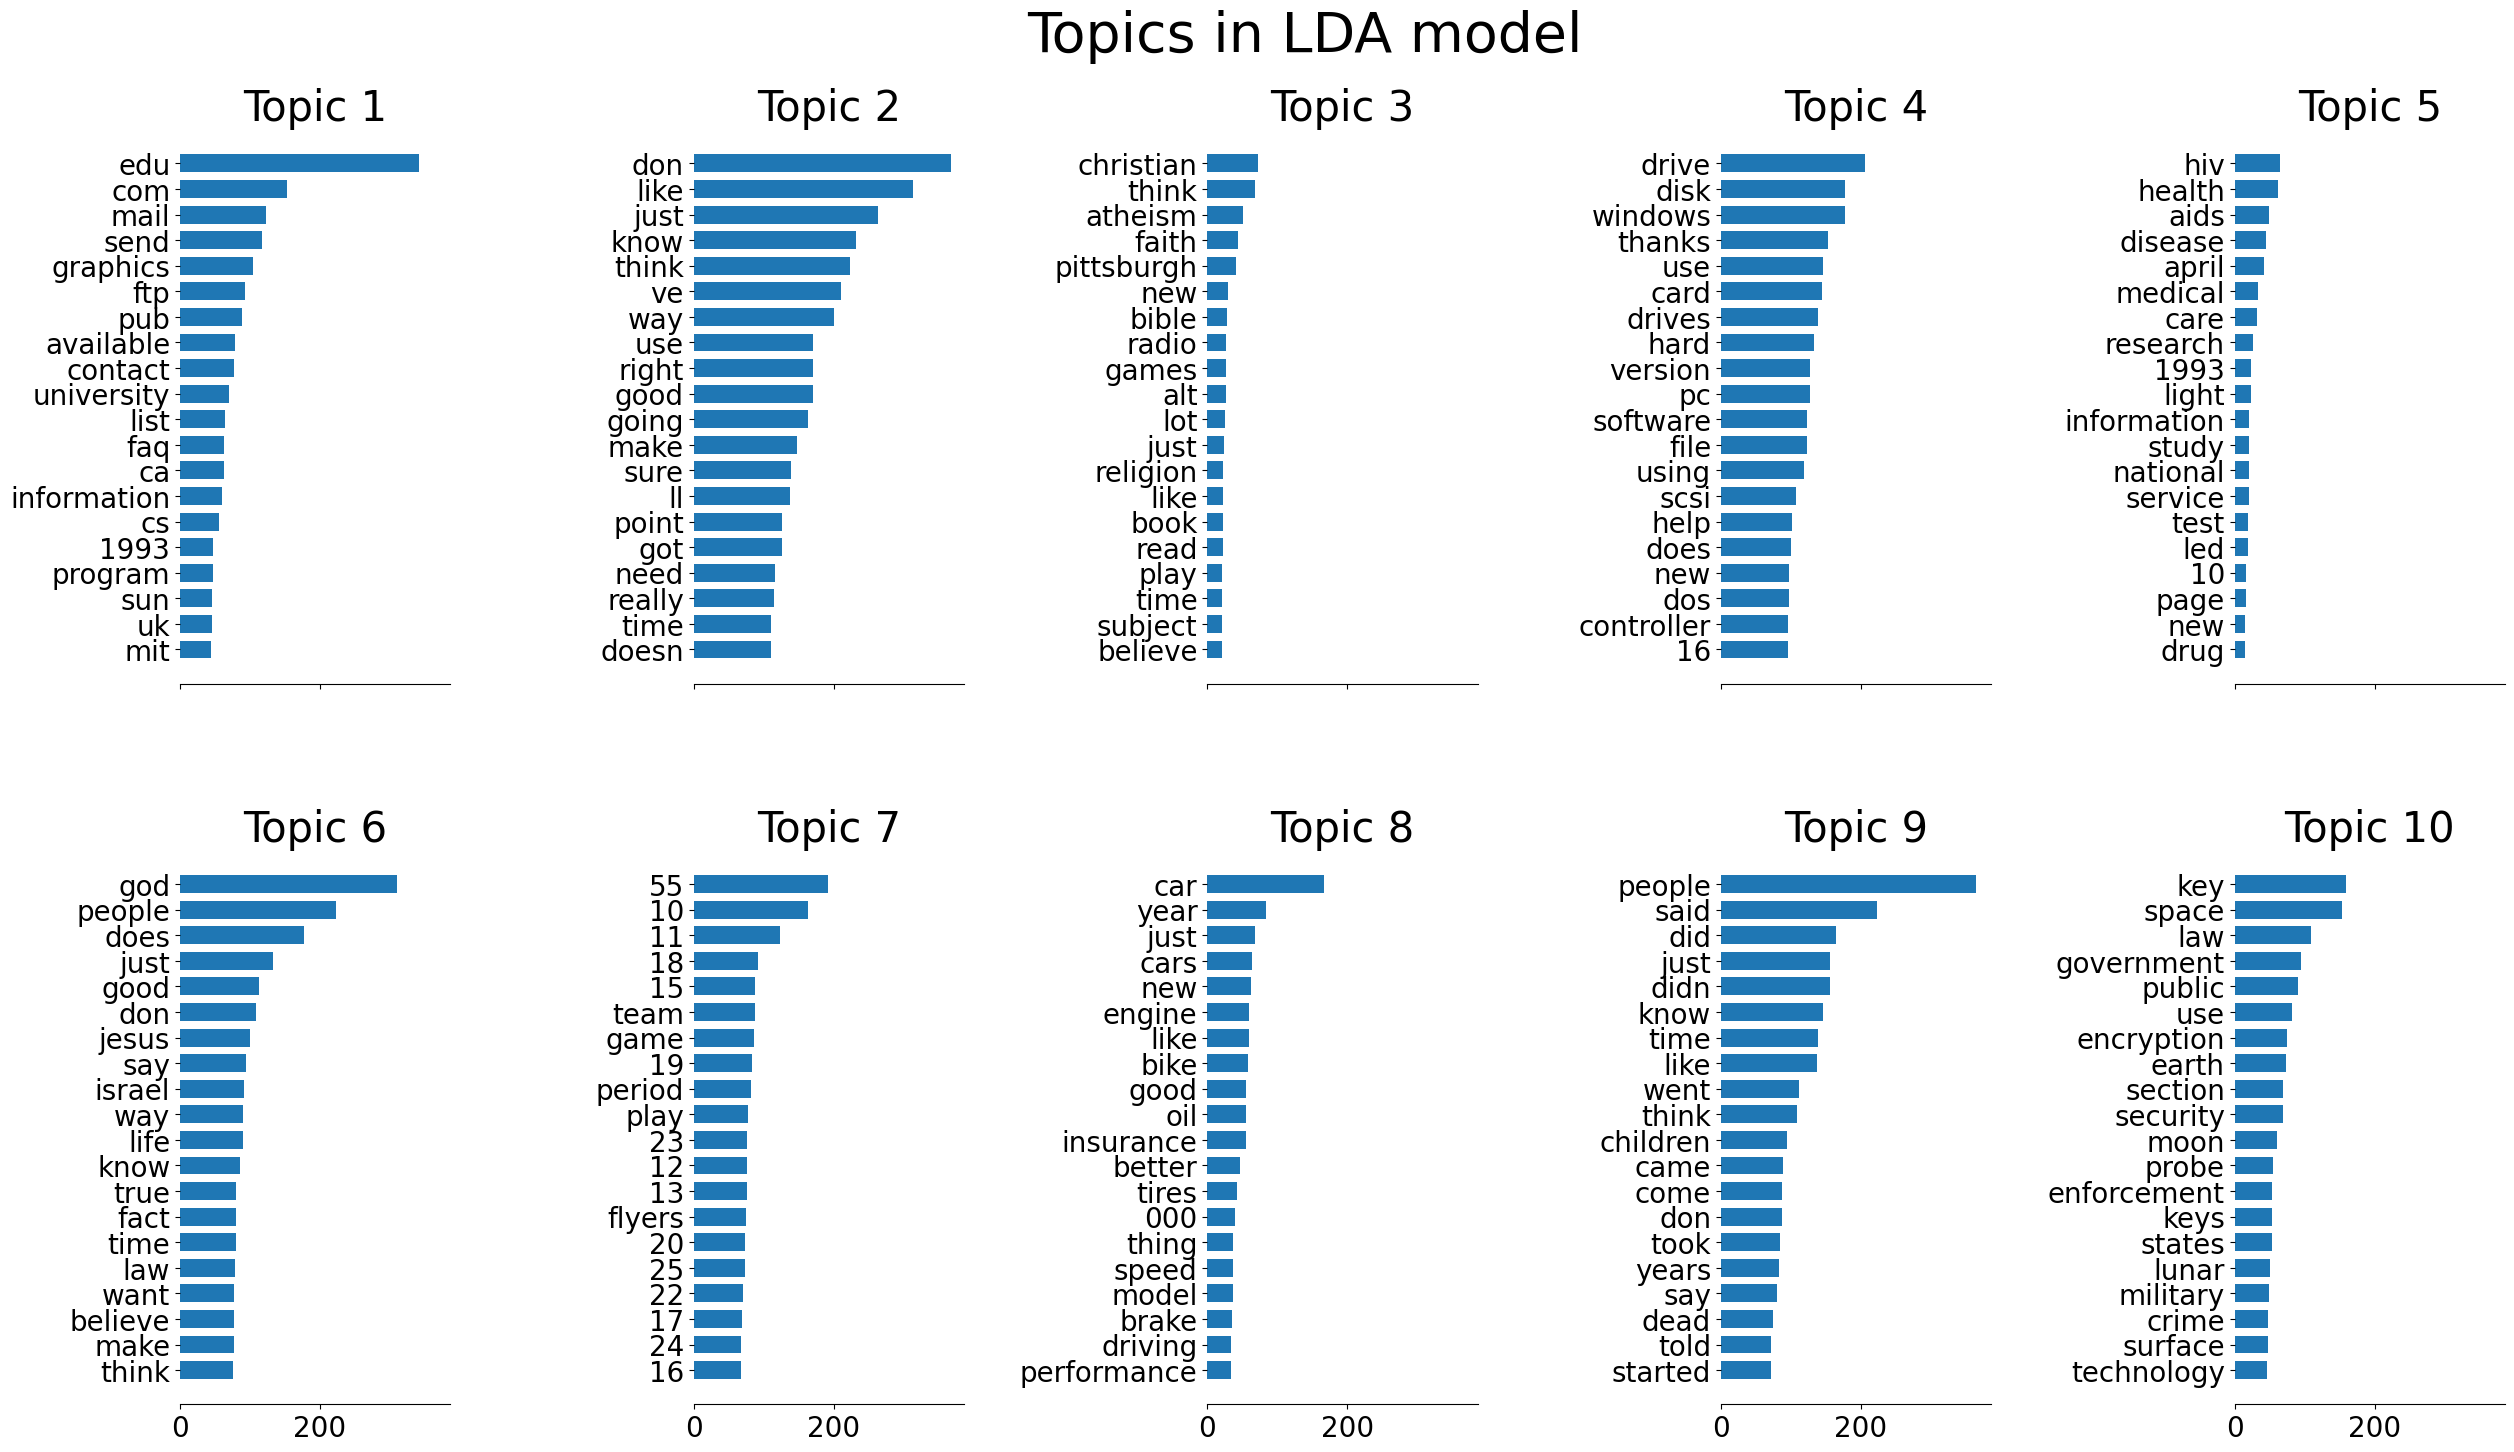

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
from time import time

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

# Summary

In this lab, we have learned how to apply Non-negative Matrix Factorization and Latent Dirichlet Allocation on a corpus of documents to extract additive models of the topic structure of the corpus. We have also learned how to plot the topics, each represented as a bar plot using the top few words based on weights.